In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Step 1: Load the dataset
data = pd.read_excel("yahoo_data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
data.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2023-04-28,33797.43,34104.56,33728.40,34098.16,34098.16,354310000
2023-04-27,33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2023-04-26,33596.34,33645.83,33235.85,33301.87,33301.87,321170000
2023-04-25,33828.34,33875.49,33525.39,33530.83,33530.83,297880000
2023-04-24,33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2023-04-28 to 2018-05-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1258 non-null   float64
 1   High         1258 non-null   float64
 2   Low          1258 non-null   float64
 3   Close*       1258 non-null   float64
 4   Adj Close**  1258 non-null   float64
 5   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


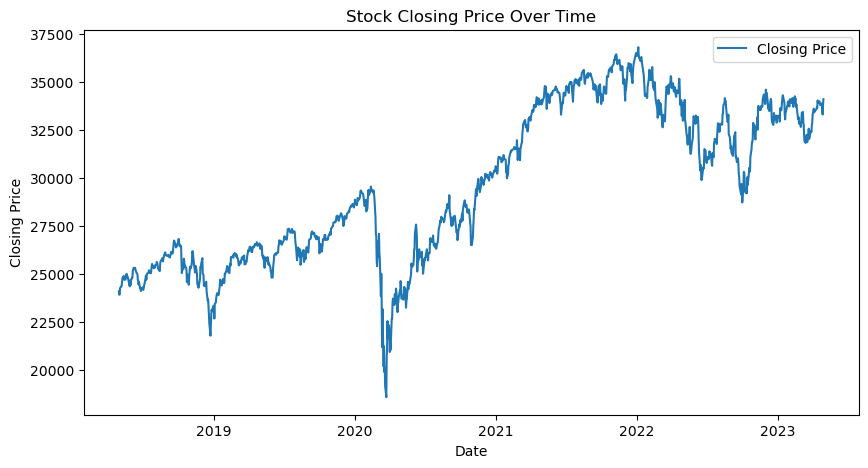

In [3]:
# Step 2: Visualizing Stock Price Trends
plt.figure(figsize=(10, 5))
plt.plot(data['Close*'], label='Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [4]:
# Step 3: ARIMA Model for Forecasting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


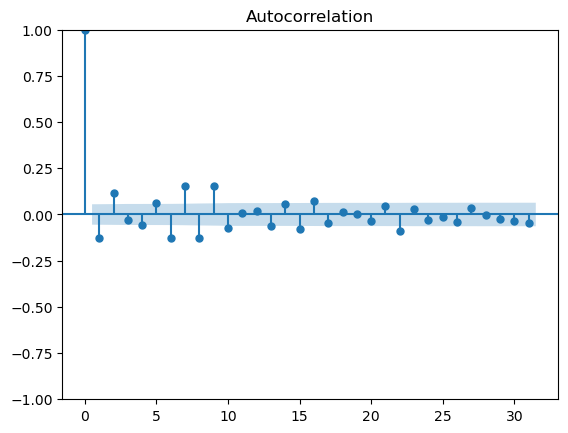

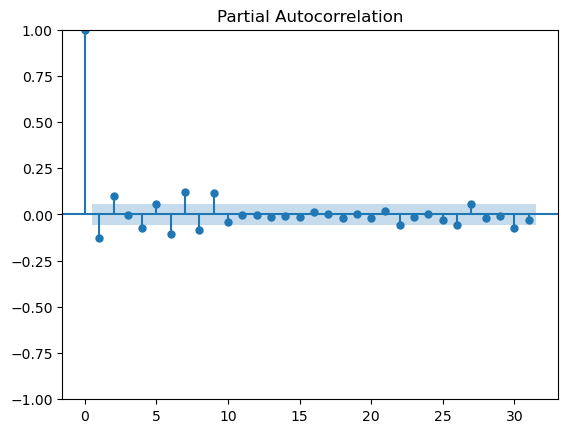

In [5]:
# Plot ACF and PACF
data_diff = data['Close*'].diff().dropna()
plot_acf(data_diff)
plot_pacf(data_diff)
plt.show()

In [6]:
# Fitting ARIMA Model
model = ARIMA(data['Close*'], order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)
print("ARIMA Forecast:", forecast)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-

ARIMA Forecast: 1258    24080.794013
1259    24088.785259
1260    24085.287228
1261    24086.818431
1262    24086.148173
1263    24086.441567
1264    24086.313139
1265    24086.369356
1266    24086.344748
1267    24086.355520
Name: predicted_mean, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [7]:
# Step 4: LSTM Model for Forecasting
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close*']])

train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [8]:
# Prepare LSTM data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [9]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
63/63 [==============================] - 14s 56ms/step - loss: 0.0383 - val_loss: 0.0064
Epoch 2/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0022 - val_loss: 8.9856e-04
Epoch 3/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0017 - val_loss: 8.1763e-04
Epoch 4/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 6.9221e-04
Epoch 5/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 7.3872e-04
Epoch 6/20
63/63 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 6.6091e-04
Epoch 7/20
63/63 [==============================] - 1s 24ms/step - loss: 0.0015 - val_loss: 7.7078e-04
Epoch 8/20
63/63 [==============================] - 1s 24ms/step - loss: 0.0017 - val_loss: 6.3614e-04
Epoch 9/20
63/63 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 7.1470e-04
Epoch 10/20
63/63 [==============================] - 1s 23ms/step - loss: 0.

In [12]:
# Predict Future Prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 2s 9ms/step


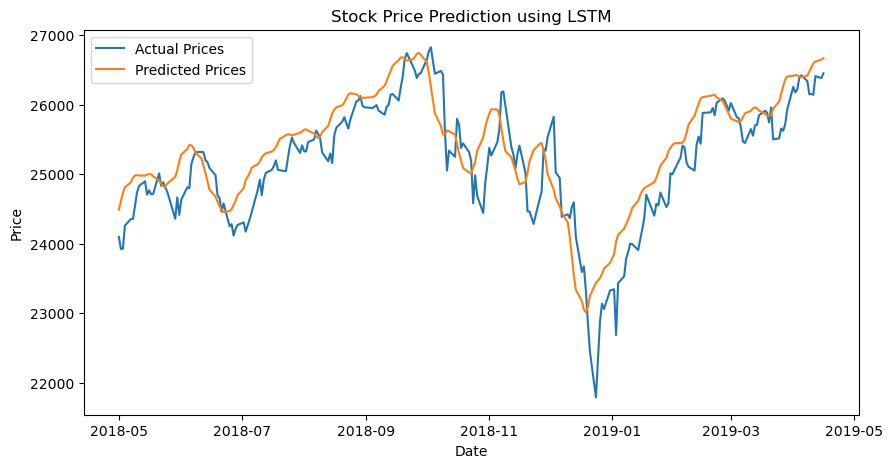

In [13]:
# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()